# Generative process

## Definitions

We can generate participants' biomarker data according to EBM (Event-Based Model). 

$S \sim {\rm UniformPermutation}(\cdot)$

$S$ follows a distribution of uniform permutation. That means the ordering of biomarkers is random. 

$k_j \sim {\rm DiscreteUniform}(N)$

$k_j$ follows a discrete uniform distribution, which means a participant is equally likely to fall in a progression stage (e.g., from $0$ to $4$, where $0$ indicate this participant is healthy.)

$$X_{S(n)j} | S, k_j  \sim I(z_j == 1) \left[ I(S(n) \leq k_j ) p(X_{S(n)j} \mid \theta_{S(n)} ) +I(S(n) \gt k_j) p(X_{S(n)j} \mid \phi_{S(n)}) \right] +  \left(1-I(z_j==1) \right) p(X_{S(n)j} \mid \phi_{S(n)})$$

Note that $\sim$ in statistics indicates that this variable follows a certain distribution. Here, it means that the biomarker values is drawn from that distribution. 

## Parameters

$z_j$: $1$ if the participant is diseased; otherwise $0$.

$I(True) = 1$, $I(False) = 0$

$S$ denotes the ordering of a sequence of biomarkers. 

$N$: number of observed biomarkers.

$n$: a specific biomarker; e.g., biomarker $b$.

$J$: number of participants. 

$j$ denotes a participant. 

$X$ is observed values of biomarkers; it is a matrix of dimension of $N \times J$ or $J \times N$.

$k$: a scalar whose value is the participant's stage of the disease

$K$: number of disease stages

$S(n)$ means the disease stage that a specific biomarker $n$ indicates. 

$k_j$: disease stage that a participant is at. 

$X_{nj}$ means the observed value of the biomarker $n$ in participant $j$. 

$\theta_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has been affected by the disease. Let's assume this distribution is a Gaussian distribution.

$\phi_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has NOT been affected by the disease. 

## Simulation

**We are going to generate biomarker values for each participant by randomly drawing from distributions defined by $\theta$ or $\phi$. We will base our generation on Chen's paper (Figure 1).**

![](./img/chen_fig1.png)

In [69]:
import numpy as np
import scipy.stats as stats
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
n_participants = 100

In the following, let's first get the real theta and phi for each of the ten biomarkers. Remember that theta is abnormal and phi is normal:

In [71]:
all_ten_biomarker_names = np.array([
    'MMSE', 'ADAS', 'AB', 'P-Tau', 'HIP-FCI', 
    'HIP-GMI', 'AVLT-Sum', 'PCC-FCI', 'FUS-GMI', 'FUS-FCI'])
# in the order above
# cyan, normal
phi_means = [28, -6, 250, -25, 5, 0.4, 40, 12, 0.6, -10]
# black, abnormal
theta_means = [22, -20, 150, -50, -5, 0.3, 20, 5, 0.5, -20]
# cyan, normal
phi_std_times_three = [2, 4, 150, 50, 5, 0.7, 45, 12, 0.2, 10]
phi_stds = [std_dev/3 for std_dev in phi_std_times_three]
# black, abnormal
theta_std_times_three = [8, 12, 50, 100, 20, 1, 20, 10, 0.2, 18]
theta_stds = [std_dev/3 for std_dev in theta_std_times_three]

In [72]:
# theta_means = [1, 3, 5, 6, 8, 0, 4, 2, 7, 9]
# theta_stds = [0.3, 0.5, 0.2, 1.3, 3.3, 2.2, 0.8, 0.9, 0.7, 0.6]
# phi_means = [32, 31, 34, 36, 38, 39, 30, 33, 35, 37]
# phi_stds = [6.3, 7.4, 9.4, 4.9, 2.5, 5.9, 6.4, 7.7, 8.0, 3.0]

In [73]:
# S_ordering = np.array([
#     'HIP-FCI', 'PCC-FCI', 'AB', 'P-Tau', 'MMSE', 'ADAS', 
#     'HIP-GMI', 'AVLT-Sum', 'FUS-GMI', 'FUS-FCI'
#     ])
biomarkers_used_in_chen_data = np.array([
    'HIP-FCI', 'HIP-GMI', 'FUS-FCI', 'PCC-FCI', 'FUS-GMI'
])
S_ordering_in_chen_data = np.array([
    'HIP-FCI', 'PCC-FCI', 'HIP-GMI', 'FUS-GMI', 'FUS-FCI'
])
# chen ordering: [1, 3, 5, 2, 4]

In [74]:
## We only use five biomarkers for simplicity reasons
biomarkers = biomarkers_used_in_chen_data
S_ordering = S_ordering_in_chen_data
n_biomarkers = len(biomarkers)

In [75]:
# to get the real_theta_phi means and stds
dict_list = []
for i, biomarker in enumerate(biomarkers):
    dic = {"biomarker": biomarker}
    dic['theta_mean'] = theta_means[i]
    dic['theta_std'] = theta_stds[i]
    dic['phi_mean'] = phi_means[i]
    dic['phi_std'] = phi_stds[i]
    dict_list.append(dic)
real_theta_phi = pd.DataFrame(dict_list)
real_theta_phi

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,HIP-FCI,22,2.666667,28,0.666667
1,HIP-GMI,-20,4.000000,-6,1.333333
2,FUS-FCI,150,16.666667,250,50.000000
3,PCC-FCI,-50,33.333333,-25,16.666667
4,FUS-GMI,-5,6.666667,5,1.666667


In [76]:
real_theta_phi.to_csv('data/means_stds.csv', index=False)

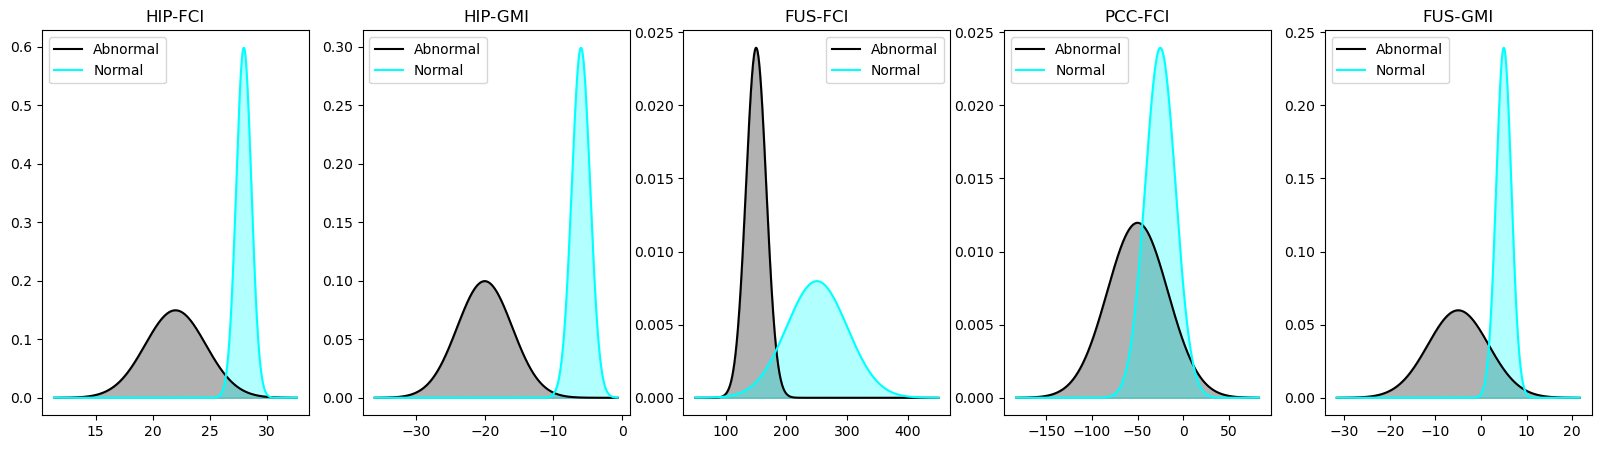

In [77]:
def plot_distribution_pair(ax, mu1, sigma1, mu2, sigma2, title):
    """mu1, sigma1: theta
    mu2, sigma2: phi
    """
    xmin = min(mu1 - 4*sigma1, mu2-4*sigma2)
    xmax = max(mu1 + 4*sigma1, mu2 + 4*sigma2)
    x = np.linspace(xmin, xmax, 1000)
    y1 = stats.norm.pdf(x, loc = mu1, scale = sigma1)
    y2 = stats.norm.pdf(x, loc = mu2, scale = sigma2)
    ax.plot(x, y1, label = "Abnormal", color = "black")
    ax.plot(x, y2, label = "Normal", color = "cyan")
    ax.fill_between(x, y1, alpha = 0.3, color = "black")
    ax.fill_between(x, y2, alpha = 0.3, color = "cyan")
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, n_biomarkers, figsize=(20, 5))
for i, biomarker in enumerate(biomarkers):
    ax = axes.flatten()[i] 
    mu1, sigma1, mu2, sigma2 = real_theta_phi[
        real_theta_phi.biomarker == biomarker].reset_index().iloc[0, :][2:].values
    plot_distribution_pair(
        ax, mu1, sigma1, mu2, sigma2, title = biomarker)

In [78]:
for n, biomarker in enumerate(biomarkers):
    print(n, biomarker)

0 HIP-FCI
1 HIP-GMI
2 FUS-FCI
3 PCC-FCI
4 FUS-GMI


In [79]:
def simulate_ebm(
        biomarkers, S_ordering, n_participants, real_theta_phi):
    """
    Simulate an Event-Based Model (EBM) for disease progression.
    
    Args:
    biomarkers: Biomarker names
    S_ordering: Biomarker names ordered according to the order 
        in which each of them get affected 
    by the disease
    n_participants (int): Number of participants.
    real_theta_phi: pandas dataframes of theta and phi values for all biomarkers
    
    Returns:
    tuple: A tuple containing:
        - kjs (numpy.ndarray): The disease stages for participant.
        - X (numpy.ndarray): The biomarker matrix with participant data.
          - Each cell in X is tuple containing participantId, biomarker name, biomarker value, 
            disease stage of this participant, disease stage current biomarker indicates
            and healthy status
    """
    # N (int): Number of biomarkers.
    n_biomarkers = len(biomarkers)
    n_stages = n_biomarkers + 1
    
    # Generate a random stage for each participant
    # The stage should be between 0 and N, inclusive
    # stage 0 indicate the participant is healthy (normal)
    kjs = np.random.randint(0, n_stages, size=n_participants)
    
    # Initiate biomarker measurement matrix (J participants x N biomarkers), 
    # with entries as None
    X = np.full((n_participants, n_biomarkers), None, dtype=object)
    
    # biomarker : normal distribution
    theta_dist = {biomarker: stats.norm(
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['theta_mean'][0],
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['theta_std'][0]
        ) for biomarker in biomarkers}
    phi_dist = {biomarker: stats.norm(
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['phi_mean'][0],
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['phi_std'][0]
        ) for biomarker in biomarkers}

    # Iterate through participants
    for j in range(n_participants):
        # Iterate through biomarkers
        for n, biomarker in enumerate(biomarkers):
            # Disease stage of the current participant
            k_j = kjs[j]
            # Disease stage indicated by the current biomarker
            # Note that biomarkers always indicate that the participant is diseased
            # Thus, S_n >= 1
            S_n = np.where(S_ordering == biomarker)[0][0] + 1
            
            # Assign biomarker values based on the participant's disease stage 
            # affected, or not_affected, is regarding the biomarker, not the participant
            if k_j >= 1:
                if k_j >= S_n:
                    X[j, n] = (j, biomarker, theta_dist[biomarker].rvs(), k_j, S_n, 'affected') 
                else:
                    X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(), k_j, S_n, 'not_affected')  
            # if the participant is healthy
            else:
                X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(), k_j, S_n, 'not_affected')        
    return kjs, X

In [80]:
kjs, X = simulate_ebm(biomarkers, S_ordering, n_participants, real_theta_phi)

`X` is a `n_participants` $\times$ `n_biomarkers` matrix. Each row is a participant and each column is for a biomarker. Each cell is a tuple containing the following information: 

- participant id
- biomarker name
- biomarker measurement
- disease stage this participant is in
- disease stage this biomarker represents
- whether this biomarker is affected by this disease 

In [81]:
pd.DataFrame(X).head(3)

,0,1,2,3,4
0,"(0, HIP-FCI, 23.23907659372394, 5, 1, affected)","(0, HIP-GMI, -12.733676324142387, 5, 3, affected)","(0, FUS-FCI, 146.4139080172237, 5, 5, affected)","(0, PCC-FCI, -22.232131348685655, 5, 2, affected)","(0, FUS-GMI, -6.8460678005365265, 5, 4, affected)"
1,"(1, HIP-FCI, 27.88933941915866, 0, 1, not_affe...","(1, HIP-GMI, -5.96840837317459, 0, 3, not_affe...","(1, FUS-FCI, 364.1622501272176, 0, 5, not_affe...","(1, PCC-FCI, -34.62684374033677, 0, 2, not_aff...","(1, FUS-GMI, 7.0033991426772335, 0, 4, not_aff..."
2,"(2, HIP-FCI, 19.442577645132054, 2, 1, affected)","(2, HIP-GMI, -6.851928445906906, 2, 3, not_aff...","(2, FUS-FCI, 166.76516737105075, 2, 5, not_aff...","(2, PCC-FCI, -24.593130983392513, 2, 2, affected)","(2, FUS-GMI, 7.777249729283457, 2, 4, not_affe..."


Please note that "not_affected" and "affected" are refering to a specific biomarker, rather than this participant's healthy status. 

In [82]:
df = pd.DataFrame(X, columns=biomarkers)
df
# make this dataframe wide to long 
df_long = df.melt(var_name = "Biomarker", value_name="Value")
df_long
values_df = df_long['Value'].apply(pd.Series)
values_df.columns = ['participant', "biomarker", 'measurement', 'k_j', 'S_n', 'affected_or_not']
values_df

,participant,biomarker,measurement,k_j,S_n,affected_or_not
0,0,HIP-FCI,23.239077,5,1,affected
1,1,HIP-FCI,27.889339,0,1,not_affected
2,2,HIP-FCI,19.442578,2,1,affected
3,3,HIP-FCI,18.569040,2,1,affected
4,4,HIP-FCI,24.009016,2,1,affected
...,...,...,...,...,...,...
495,95,FUS-GMI,-4.226088,4,4,affected
496,96,FUS-GMI,3.286501,3,4,not_affected
497,97,FUS-GMI,4.706064,4,4,affected
498,98,FUS-GMI,6.719479,0,4,not_affected


## Visualizing simulated results

With the above data structure, we can visualize the following data:

- Distribution of all biomarker values by biomarker
- Distribution of all biomarker values when the participant is at a certain disease stage
- Comparing a certain biomarker data 
- A certain participant's data

### Distribution of all biomarker values by biomarker

In [83]:
df = pd.DataFrame(X, columns=biomarkers)
# make this dataframe wide to long 
df_long = df.melt(var_name = "Biomarker", value_name="Value")
values_df = df_long['Value'].apply(pd.Series)
values_df.columns = ['participant', "biomarker", 'measurement', 'k_j', 'S_n', 'affected_or_not']
df = values_df

alt.Chart(df).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 140,
    height = 200,
).properties(
    title='Biomarker data for all participants across all stages'
)

alt.Chart(...)

In [84]:
df.to_csv("data/participant_data.csv", index=False)
df.head()

,participant,biomarker,measurement,k_j,S_n,affected_or_not
0,0,HIP-FCI,23.239077,5,1,affected
1,1,HIP-FCI,27.889339,0,1,not_affected
2,2,HIP-FCI,19.442578,2,1,affected
3,3,HIP-FCI,18.569040,2,1,affected
4,4,HIP-FCI,24.009016,2,1,affected


In [85]:
# df[df.k_j == 0]

### Distribution of all biomarker values when the participant is at a certain disease stage

In [86]:
# biomarker data when the participant is at stage 6
df_kj_3 = df[df.k_j == 3]
df_kj_3

alt.Chart(df_kj_3).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 140,
    height = 200,
).properties(
    title='Biomarker data when the participant is at stage six'
)

alt.Chart(...)

### Comparing a certain biomarker data 

In [87]:
# select a biomarker
bio_data = df[df.biomarker=='HIP-FCI'].drop(['k_j', 'S_n', 'biomarker'], axis = 1)
# biomarker2 data, comparing from diseased and healthy groups
alt.Chart(bio_data).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['affected_or_not']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "affected_or_not:N",
    ),
    color=alt.Color(
        'affected_or_not:N'
    )
).properties(
    width= 240,
    height = 200,
).properties(
    title='HIP-FCI data, compring healthy group and diseased group'
)

alt.Chart(...)

### A certain participant's data

In [88]:
# participant 10
participant10_data = df[df.participant == 10]
alt.Chart(participant10_data).mark_bar().encode(
    x='biomarker',
    y='measurement',
    color=alt.Color(
        'affected_or_not:N'
    ),
    tooltip=['biomarker', 'affected_or_not', 'measurement']
).interactive().properties(
    title=f'Biomarker data for participant 10 (k_j = {participant10_data.k_j.to_list()[0]})'
)

alt.Chart(...)